In [1]:
#Step 1: Load and Preprocess the Data
#We need to combine both customer profile data (from Customers.csv) and transaction data (from Transactions.csv) to create a feature set for clustering. This includes:

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
customers = pd.read_csv('/kaggle/input/zeotap-pdataset/Data.csv/Customers.csv')
products = pd.read_csv('/kaggle/input/zeotap-pdataset/Data.csv/Products.csv')
transactions = pd.read_csv('/kaggle/input/zeotap-pdataset/Data.csv/Transactions.csv')

# Merging transaction and product data to get product information
transactions = transactions.merge(products[['ProductID', 'Category']], on='ProductID', how='left')


In [3]:
#Step 2: Feature Engineering for Customer Profiles
#We need to aggregate transaction data for each customer and combine it with demographic information. The features will include:

# Aggregating transaction data by customer
customer_transactions = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',        # Total spending per customer
    'Quantity': 'sum',          # Total number of products bought
    'ProductID': 'nunique',     # Number of unique products bought
}).reset_index()

# Aggregating by product category
category_sales = transactions.groupby(['CustomerID', 'Category'])['TotalValue'].sum().unstack(fill_value=0)

# Merging customer profile data with transaction history
customer_profile = customers.set_index('CustomerID').join(customer_transactions.set_index('CustomerID')).join(category_sales, on='CustomerID', how='left').reset_index()

# Fill missing values if necessary
customer_profile.fillna(0, inplace=True)


In [4]:
#Step 3: Normalizing the Data

#Since we have mixed numerical and categorical features, we will normalize the numerical features to scale them appropriately before clustering.

# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['TotalValue', 'Quantity', 'ProductID'] + [col for col in category_sales.columns]  # Include category columns
customer_profile[numerical_features] = scaler.fit_transform(customer_profile[numerical_features])


In [6]:
#Step 4: Perform Clustering
#We will use K-Means clustering to segment customers. The number of clusters will be chosen between 2 and 10 based on evaluation metrics like the Davies-Bouldin (DB) index
# Perform K-Means clustering
# Perform K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)  # Set n_init explicitly to suppress the warning
customer_profile['Cluster'] = kmeans.fit_predict(customer_profile[numerical_features])

# Calculate Davies-Bouldin Index (DB Index)
db_index = davies_bouldin_score(customer_profile[numerical_features], customer_profile['Cluster'])


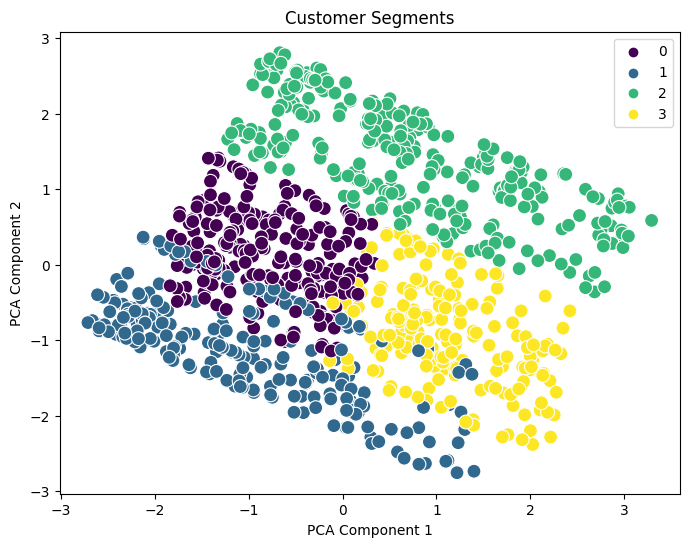

Number of Clusters: 4
DB Index: 1.391609754323979
Silhouette Score: 0.2982928866134436
Inertia: 3017.745613829656


In [16]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Load the data
customers = pd.read_csv('/kaggle/input/zeotap-pdataset/Data.csv/Customers.csv')
transactions = pd.read_csv('/kaggle/input/zeotap-pdataset/Data.csv/Transactions.csv')

# Data preprocessing (merging datasets, handling missing values, etc.)
# Merging Customers and Transactions data on 'CustomerID'
data = pd.merge(customers, transactions, on='CustomerID')

# Feature Engineering
# Convert 'SignupDate' to datetime and create a numerical feature (days since signup)
data['SignupDate'] = pd.to_datetime(data['SignupDate'])
data['DaysSinceSignup'] = (pd.to_datetime('today') - data['SignupDate']).dt.days

# One-hot encode the 'Region' column
data = pd.get_dummies(data, columns=['Region'], drop_first=True)

# Select relevant features for clustering (customer profile and transaction data)
features = data[['Quantity', 'TotalValue', 'DaysSinceSignup'] + [col for col in data.columns if 'Region' in col]]

# Handle missing values by filling with mean
features = features.fillna(features.mean())

# Normalize the data for better clustering performance
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Choose the number of clusters (between 2 and 10)
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')   # You can change the number of clusters as needed
clusters = kmeans.fit_predict(features_scaled)

# Evaluate the clustering
db_index = davies_bouldin_score(features_scaled, clusters)
sil_score = silhouette_score(features_scaled, clusters)
inertia = kmeans.inertia_

# Perform PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(features_scaled)

# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=clusters, palette='viridis', s=100)
plt.title('Customer Segments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Report results
print(f"Number of Clusters: {len(np.unique(clusters))}")
print(f"DB Index: {db_index}")
print(f"Silhouette Score: {sil_score}")
print(f"Inertia: {inertia}")
